**Encoder 제거 + cross-attention 제거 + 전층 masked multi-head self-attention + 학습형 포지션 임베딩 + LM head(weight tying) + 입력을 태스크별로 직렬화 **


## 1️. 전체 구조 (Encoder–Decoder → Decoder-Only)
| 항목 | Transformer           | GPT-1 변경점                   |
| -- | --------------------- | --------------------------- |
| 구성 | Encoder + Decoder     | **Encoder 제거**, Decoder만 사용 |
| 목적 | 번역(입력→출력)             | **언어모델링 (다음 단어 예측)**        |
| 입력 | (source, target) 두 문장 | **단일 시퀀스** (문맥+토큰 스트림)      |

## 2️. Self-Attention 블록
| 항목              | Transformer                                  | GPT-1 변경점                             |
| --------------- | -------------------------------------------- | ------------------------------------- |
| 어텐션 방향          | Encoder는 양방향, Decoder는 masked | **모든 블록에서 masked self-attention만 사용** |
| Cross-Attention | Decoder 내부에 Encoder 출력 참조용 존재                | **완전히 제거**                            |
| Mask 종류         | look-ahead mask + encoder–decoder mask       | **masked multi-head self-attention만 유지**         |

## 3️. 포지셔널 인코딩 (Positional Encoding)
| 항목    | Transformer   | GPT-1 변경점                            |
| ----- | ------------- | ------------------------------------ |
| 방식    | 고정형 사인/코사인 함수 | **학습형 position embedding (learned)** |
| 적용 시점 | 입력 임베딩에 더함    | 동일하게 더하지만, 파라미터 학습 가능                |

## 4️. 입력 임베딩 (Token Embedding)
| 항목     | Transformer      | GPT-1 변경점                                   |
| ------ | ---------------- | ------------------------------------------- |
| 입력 형태  | source/target 분리 | **단일 단어 시퀀스 입력**                            |
| 가중치 공유 | 별도로 정의           | **입력 임베딩과 출력 Softmax 가중치 공유(weight tying)** |

## 5️. Feed-Forward Network (FFN)
| 항목    | Transformer             | GPT-1 변경점             |
| ----- | ----------------------- | --------------------- |
| 구조    | Linear → ReLU → Linear  | 동일 (GPT-1에서도 ReLU 유지) |
| 적용 범위 | 각 위치 독립 (position-wise) | 동일                    |

## 6️. Normalization 및 순서
| 항목           | Transformer            | GPT-1 변경점                                |
| ------------ | ---------------------- | ---------------------------------------- |
| LayerNorm 위치 | Post-Norm (Residual 뒤) | **Pre-Norm 형태로 변경**  |
| Residual 연결  | 동일하게 존재                | 동일하게 유지                                  |

## 7️. 출력층 (Language Modeling Head)
| 항목      | Transformer             | GPT-1 변경점                                       |
| ------- | ----------------------- | ----------------------------------------------- |
| 출력 대상   | 번역 단어 분포 (target vocab) | **다음 단어 확률 분포 **                            |
| Softmax | decoder output → vocab  | **마지막 hidden → vocab softmax**, weight tying 사용 |







## GPT 훈련 및 모델 설계 개요

GPT를 훈련시킬 때는 디코더 훈련에서는 **순수 텍스트**를 입력으로 사용하며,  
감정 토큰과 같은 추가 정보는 **마지막 선형 레이어를 미세 조정할 때** 투입하는 것이 일반적입니다.  

그러나 이번 메인 퀘스트에서는 편의상, 논문 내 **_Question Answering and Commonsense Reasoning_** 형식인  
`[z; q; $; a_k]` 구조를 모방하여 **처음부터 훈련 데이터에 포함하여 학습**했습니다.  

검색과 논문을 통해 다음과 같은 구성에서  
`Embedding(40, 768)` 중 **토큰 크기 40을 제외한 모든 부분을 직접 구현**하였습니다.

---

### 모델 구조

- **Decoder Layers:** 12개  
- **Embedding / Hidden Size (d_model):** 768  
- **Multi-Head Attention Heads:** 12개  
- **Feed-Forward Network Size (d_ff):** 3072  
- **활성화 함수:** GELU  
- **포지셔널 인코딩:** 학습 가능한 Learned Positional Encoding 사용  

---

### 모델 조정 배경

하드웨어 한계로 인해 여러 차례의 훈련 과정에서 **과적합(overfitting)** 이 관찰되었고,  
이에 따라 **적당히 타협 가능한 수준으로 모델 설계를 변경**하였습니다.

---

### 비교 및 검증

첫 마크다운에서는  
**GPT-1 논문**과 **Transformer 논문**을 비교하여  
두 구조 간의 차이를 서술하여 **조건 1**을 만족하고,
이어지는 단계에서는 **조건 2, 3, 4, 5**를 모두 만족함을 확인하였습니다.

## GPT-1 구조 비교
![GPT-1 구조](pics/GPT_1.png)

## 모델 학습 (model.fit)
![모델 학습 과정](pics/model.fit().png)

## 추론 결과 1 (Inference)
![추론 결과](pics/inference_result.png)

## 추론 결과 2 (Inference)
![추론 결과](pics/inference_result_2.png)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm
import math
import re
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import pandas as pd
import random


In [4]:
'''
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)


_get_angles, _build_pos_encoding 메서드 삭제
nn.Embedding(max_position, d_model) 사용
forward 시점에 실제 시퀀스 길이만큼의 위치 인덱스 생성

'''
max_seq_length = 40

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, max_position, d_model):
        super(LearnedPositionalEncoding, self).__init__()
        self.d_model = d_model
        self.max_position = max_position
        
        # 학습 가능한 positional embedding 파라미터
        self.pos_embedding = nn.Embedding(max_position, d_model)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # 위치 인덱스 생성 [0, 1, 2, ..., seq_len-1]
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        
        # Embedding lookup을 통해 학습된 positional encoding 가져오기
        pos_encodings = self.pos_embedding(positions)
        
        # 입력에 positional encoding 더하기
        return x + pos_encodings


# 데이터에 위치정보를 추가하는 클래스입니다.
# Decoder 클래스에서 위치정보를 추가 합니다.

In [5]:
'''
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights
'''

def scaled_dot_product_attention(query, key, value, mask=None):
    # query, key, value: (B, H, T, D), (B, H, S, D), (B, H, S, D)
    # 1) 점수
    logits = torch.matmul(query, key.transpose(-1, -2))  # (B, H, T, S)

    # 2) 스케일링
    depth = key.size(-1)
    logits = logits / math.sqrt(depth)

    # 3) 마스킹
    if mask is not None:
        # mask shape: (B, 1, T, S) or (B, H, T, S) → True/1이면 차단
        logits = logits.masked_fill(mask.to(dtype=torch.bool), float("-inf"))

    # 4) 소프트맥스
    attention_weights = F.softmax(logits, dim=-1)  # (B, H, T, S)

    # 5) 가중합
    output = torch.matmul(attention_weights, value)  # (B, H, T, D)
    return output, attention_weights

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0
        self.depth = d_model // num_heads

        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense   = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)
        self.out_dense   = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        # (B, L, D) -> (B, H, L, D/H)
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3).contiguous()
        return x

    def forward(self, query, key, value, mask=None):
        # query/key/value: (B, Lq/Dq), (B, Lk/Dk), (B, Lk/Dk) with D=d_model
        B = query.size(0)

        Q = self.query_dense(query)
        K = self.key_dense(key)
        V = self.value_dense(value)

        Q = self.split_heads(Q, B)  # (B,H,T,Dh)
        K = self.split_heads(K, B)  # (B,H,S,Dh)
        V = self.split_heads(V, B)  # (B,H,S,Dh)

        # mask: (B,1,T,S) or (B,H,T,S)
        out, _ = scaled_dot_product_attention(Q, K, V, mask=mask)

        # (B,H,T,Dh) -> (B,T,H,Dh) -> (B,T,D)
        out = out.permute(0, 2, 1, 3).contiguous()
        out = out.view(B, -1, self.d_model)
        return self.out_dense(out)
'''



class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


'''


'\n\n\n\nclass MultiHeadAttention(nn.Module):\n    def __init__(self, d_model, num_heads, name="multi_head_attention"):\n        super(MultiHeadAttention, self).__init__()\n        self.num_heads = num_heads\n        self.d_model = d_model\n\n        # d_model은 num_heads로 나누어떨어져야 함\n        assert d_model % num_heads == 0\n\n        self.depth = d_model // num_heads\n\n        # 파이토치에서 Dense는 nn.Linear로 대응\n        self.query_dense = nn.Linear(d_model, d_model)\n        self.key_dense = nn.Linear(d_model, d_model)\n        self.value_dense = nn.Linear(d_model, d_model)\n\n        self.out_dense = nn.Linear(d_model, d_model)\n\n    def split_heads(self, x, batch_size):\n        """\n        x: (batch_size, seq_len, d_model)\n        => (batch_size, num_heads, seq_len, depth) 형태로 변환\n        """\n        x = x.view(batch_size, -1, self.num_heads, self.depth)\n        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)\n        return x\n\n    def forward(self, query, key

In [7]:
'''
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2

인코더 레이어 불필요.
'''
pass

In [8]:


'''
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        
        #self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)
        self.pos_encoding = PositionalEncoding(position=max_seq_length, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x
    
인코더 불필요.

'''

pass

In [9]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        #self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        #self.norm2 = nn.LayerNorm(d_model, eps=1e-6)
        # cross-attention 은 불필요

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.GELU(),                   # activation='GELU' 
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, look_ahead_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        #encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        #encdec_attn_out = self.dropout2(encdec_attn_out)
        #out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> GELU -> Dense)
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out)
        out2 = self.norm2(out1 + ffn_out)  # 잔차 연결 + LayerNorm

        return out2

'''
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

'''

def create_padding_mask(x, pad_id: int = 0):
    # x: (B, S)  키/밸류 시퀀스 길이에 맞춘 입력
    mask = (x == pad_id).unsqueeze(1).unsqueeze(1).float()  # (B,1,1,S)
    return mask

def create_look_ahead_mask(x):
    # x: (B, T)  쿼리 시퀀스 길이에 맞춘 입력
    B, T = x.size()
    # 상삼각(미래) = 1, 나머지 = 0
    la = torch.triu(torch.ones((T, T), device=x.device), diagonal=1)  # (T,T)
    la = la.unsqueeze(0).unsqueeze(1).float()  # (1,1,T,T)
    return la


# 기존 코드와 동일

In [10]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1,
                 max_seq_length=max_seq_length
                 ):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # vocab_size에 맞추지않고 최대 시퀀스 길이
        #self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)
        self.pos_encoding = LearnedPositionalEncoding(max_position=max_seq_length, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        #LayerNorm + LM head 추가
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight  # weight tying

    def forward(self, x, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x,look_ahead_mask) # enc_outputs, padding_mask 제거
        logits = self.lm_head(x) 

        return logits

In [11]:
'''
class GPT_1(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # num_layers = 12로 fix
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(GPT_1, self).__init__()

        # 인코더 불필요
        #self.encoder = Encoder(
            #vocab_size=vocab_size,
            #num_layers=num_layers,
            #ff_dim=units,
            #d_model=d_model,
            #num_heads=num_heads,
            #dropout=dropout
        #)

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성 제거
        # enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        # dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits
'''
class GPT_1(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # num_layers = 12로 fix
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1,
                 ):
        super(GPT_1, self).__init__()

        # 인코더 불필요 
        # self.encoder = Encoder(
        #     vocab_size=vocab_size,
        #     num_layers=num_layers,
        #     ff_dim=units,
        #     d_model=d_model,
        #     num_heads=num_heads,
        #     dropout=dropout
        # )

        # 디코더 
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            max_seq_length=max_seq_length
        )

        # 디코더가 hidden을 반환한다면 사용
        # 디코더에서 정의했기 때문에 주석처리
        # self.final_linear = nn.Linear(d_model, vocab_size)

    def forward(self, dec_inputs):
        # 인코더 마스크/출력 불필요
        # enc_padding_mask = create_padding_mask(inputs)
        # dec_padding_mask = create_padding_mask(inputs)

        # look-ahead + padding 결합 마스크 (디코더 입력 기준)
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # (B,1,T,T)

        # 디코더 수행
        # enc_outputs=None, padding_mask=None (cross-attn 제거)
        dec_outputs = self.decoder(
            x=dec_inputs,                 # (B, T)
            #enc_outputs=None,             # 사용 안 함
            look_ahead_mask=look_ahead_mask,
            padding_mask=None
        )  # 디코더가 hidden 또는 logits을 반환

        # 1) 디코더가 hidden을 반환하는 경우 (기존 코드 유지)
        #logits = self.final_linear(dec_outputs)

        # 2) 디코더가 이미 logits을 반환하도록 구현.
        logits = dec_outputs

        return logits





In [12]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 12     # 디코더 층 수
D_MODEL = 512      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 2048      # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 16000 # 단어 집합 크기(예시)
'''
검색과 논문을 통해서 Embedding(40, 768)에서 토큰 크기 40을 제외한 모든 부분을 구현.

Decoder Layers: 12개
Embedding/Hidden Size (d_model): 768
Multi-Head Attention Heads: 12개
Feed-Forward Network Size (d_ff): 3072
활성화 함수: GELU
학습 가능한 포지셔널 인코딩 사용

'''
# 모델 생성
model = GPT_1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

GPT_1(
  (decoder): Decoder(
    (embedding): Embedding(16000, 512)
    (pos_encoding): LearnedPositionalEncoding(
      (pos_embedding): Embedding(40, 512)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (dec_layers): ModuleList(
      (0-11): 12 x DecoderLayer(
        (self_mha): MultiHeadAttention(
          (query_dense): Linear(in_features=512, out_features=512, bias=True)
          (key_dense): Linear(in_features=512, out_features=512, bias=True)
          (value_dense): Linear(in_features=512, out_features=512, bias=True)
          (out_dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (norm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        (dropo

In [13]:
# 데이터 폴더 경로
path = 'ChatbotData.csv'

label
0    5290
1    3570
2    2963
Name: count, dtype: int64


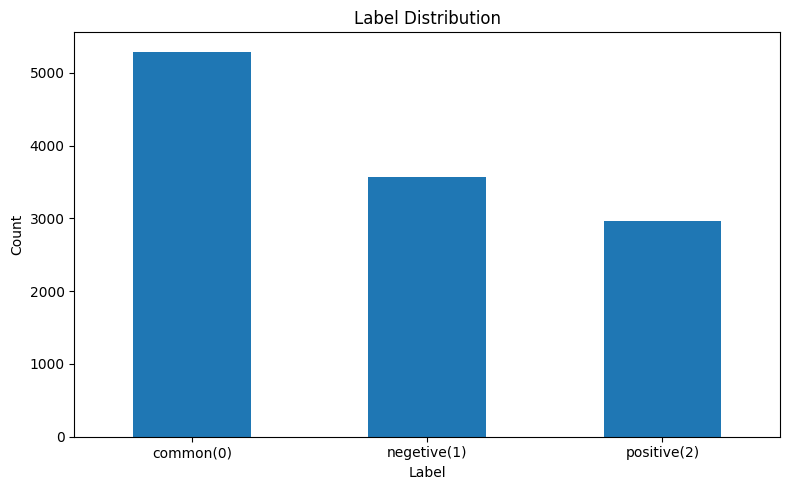

'\n라벨 마다 갯수 차이가 남\n0번 레이블의 답변이 매끄럽지 않을까? 하는 생각이 듦\n'

In [14]:
df = pd.read_csv('ChatbotData.csv')

# 레이블 분포 확인
print(df['label'].value_counts())

# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['common(0)', 'negetive(1)', 'positive(2)'], rotation=0)
plt.tight_layout()
plt.show()


'''
라벨 마다 갯수 차이가 남
0번 레이블의 답변이 매끄럽지 않을까? 하는 생각이 듦
'''

In [15]:
def preprocess_sentence(sentence):
    # 1. 유니코드 정규화
    sentence = unicodedata.normalize("NFC", sentence)

    # 2. 문장부호 앞뒤에 공백 삽입
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"\s+", " ", sentence)

    # 3. 허용 문자만 유지 (한글, 자모, 영문, 숫자, 공백, 주요 문장부호)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣA-Za-z0-9?.!,~… ]", " ", sentence)

    # 4. 감정 표현 반복 상한 (4개 이상 → 2개)
    sentence = re.sub(r'(ㅋ)\1{3,}', r'\1\1', sentence)
    sentence = re.sub(r'(ㅎ)\1{3,}', r'\1\1', sentence)
    sentence = re.sub(r'(ㅠ)\1{3,}', r'\1\1', sentence)
    sentence = re.sub(r'(ㅜ)\1{3,}', r'\1\1', sentence)

    # 5. 공백 정리
    sentence = re.sub(r"\s+", " ", sentence).strip()
    return sentence

In [16]:
def load_chatbot_csv(path,preprocess_sentence):
    """
    반환: [(Q_clean, A_clean, label), ...]
    """
    df = pd.read_csv(path)
    qs = df["Q"].astype(str).map(preprocess_sentence)
    as_ = df["A"].astype(str).map(preprocess_sentence)
    labels = df["label"].astype(int)
    return list(zip(qs, as_, labels))

In [17]:
data = load_chatbot_csv(path, preprocess_sentence)

def sanitize_keep_tags(s: str) -> str:
    # 탭/캐리지리턴만 제거. <, >, $ 보존.
    return s.replace("\t", " ").replace("\r", " ").strip()

with open("clean_corpus.txt", "w", encoding="utf-8") as f:
    for q, a, label in data:
        if q and a:
            q_ = sanitize_keep_tags(q)
            a_ = sanitize_keep_tags(a)
            # 단일 시퀀스: [q ; $ ; a]
            text = f"<user> {q_} $ <assistant> {a_}" # [z;q;$;ak​]
            f.write(f"{label}\t{text}\n")


# 단일 시퀀스. 특수토큰은 SPM에서 처리
# 논문 내 Question Answering and Commonsense Reasoning 형식 // [z;q;$;ak​]

In [18]:
spm.SentencePieceTrainer.Train(
    input='clean_corpus.txt',
    model_prefix="chatbot_spm",
    vocab_size=16000,
    character_coverage=0.9995,
    model_type="bpe",  # 한국어면 unigram도 가능
    max_sentence_length=999999,

    pad_id=0,   # <pad>
    unk_id=1,   # <unk>
    bos_id=2,   # <s>
    eos_id=3,   # </s>

    # 사용자 정의 토큰: 라벨 대신 역할 기반 /  라벨도
    user_defined_symbols=[
        "<user>", "<assistant>", "<label_0>", "<label_1>", "<label_2>", "$"
    ]
)


'''
감정 label이 존재하여, 

spm에서 label을 포함한 사용자 정의 토큰 정의

label_token = self.label_map[label] 으로 

spm 모델에 정의된 토큰 ID를 동적으로 가져오는 부분 추가

>>> 감정 + Q 형태로 학습 진행됨을 확인

'''

'\n감정 label이 존재하여, \n\nspm에서 label을 포함한 사용자 정의 토큰 정의\n\nlabel_token = self.label_map[label] 으로 \n\nspm 모델에 정의된 토큰 ID를 동적으로 가져오는 부분 추가\n\n>>> 감정 + Q 형태로 학습 진행됨을 확인\n\n'

In [19]:
sp = spm.SentencePieceProcessor()
sp.Load("chatbot_spm.model")

True

In [20]:
print(sp.piece_to_id("<label_0>"), sp.piece_to_id("<label_1>"), sp.piece_to_id("<label_2>"))

# label 0,1,2 가 토큰 4,5,6에 매핑됨을 확인


'''
<pad>	0
<unk>	0
<s>	0
</s>	0
<user>	0
<assistant>	0
<label_0>	0
<label_1>	0
<label_2>	0
$	0

전부 매핑 완료

'''

6 7 8


'\n<pad>\t0\n<unk>\t0\n<s>\t0\n</s>\t0\n<user>\t0\n<assistant>\t0\n<label_0>\t0\n<label_1>\t0\n<label_2>\t0\n$\t0\n\n전부 매핑 완료\n\n'

In [21]:
'''
class ChatbotDataset(Dataset):
    def __init__(self, data, sp, max_length=40):
        self.sp = sp
        self.max_length = max_length
        self.data = []

        # spm 모델에 정의된 토큰 ID를 동적으로 가져오기
        self.label_map = {
            0: self.sp.piece_to_id('<label_0>'),
            1: self.sp.piece_to_id('<label_1>'),
            2: self.sp.piece_to_id('<label_2>')
        }

        
        for q, a, label in data:
            bos_id = self.sp.bos_id()
            eos_id = self.sp.eos_id()
            label_token = self.label_map[label]

            q_ids = self.sp.encode_as_ids(q)
            a_ids = self.sp.encode_as_ids(a)

            q_tokens = [bos_id] + [label_token] + q_ids + [eos_id] 
            # 이전[[<label_k>][BOS] Q [EOS]]  >>> 변경[[BOS][<label_k>] Q [EOS]]
            # 얼마나 성능 향상이 있었나? 
            a_tokens = [bos_id] + a_ids + [eos_id]

            if len(q_tokens) > self.max_length or len(a_tokens) > self.max_length:
                continue

            q_tokens += [self.sp.pad_id()] * (self.max_length - len(q_tokens))
            a_tokens += [self.sp.pad_id()] * (self.max_length - len(a_tokens))

            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

q_tokens, a_tokens을 구분할 필요가 없기 때문에, Question Answering and Commonsense Reasoning
구조를 모방하여 입력

'''

'\nclass ChatbotDataset(Dataset):\n    def __init__(self, data, sp, max_length=40):\n        self.sp = sp\n        self.max_length = max_length\n        self.data = []\n\n        # spm 모델에 정의된 토큰 ID를 동적으로 가져오기\n        self.label_map = {\n            0: self.sp.piece_to_id(\'<label_0>\'),\n            1: self.sp.piece_to_id(\'<label_1>\'),\n            2: self.sp.piece_to_id(\'<label_2>\')\n        }\n\n\n        for q, a, label in data:\n            bos_id = self.sp.bos_id()\n            eos_id = self.sp.eos_id()\n            label_token = self.label_map[label]\n\n            q_ids = self.sp.encode_as_ids(q)\n            a_ids = self.sp.encode_as_ids(a)\n\n            q_tokens = [bos_id] + [label_token] + q_ids + [eos_id] \n            # 이전[[<label_k>][BOS] Q [EOS]]  >>> 변경[[BOS][<label_k>] Q [EOS]]\n            # 얼마나 성능 향상이 있었나? \n            a_tokens = [bos_id] + a_ids + [eos_id]\n\n            if len(q_tokens) > self.max_length or len(a_tokens) > self.max_length:\n                c

In [22]:
class ChatbotDataset(Dataset):
    def __init__(self, data, sp, max_length=80):
        self.sp = sp
        self.max_length = max_length
        self.data = []

        # 라벨 토큰 ID
        self.label_map = {
            0: self.sp.piece_to_id("<label_0>"),
            1: self.sp.piece_to_id("<label_1>"),
            2: self.sp.piece_to_id("<label_2>")
        }

        bos_id = self.sp.bos_id()
        eos_id = self.sp.eos_id()
        pad_id = self.sp.pad_id()
        dollar_id = self.sp.piece_to_id("$") # dollar_id 변수는 불필요하나, 나중에 토큰 검사하려고 넣어둠

        for q, a, label in data:
            label_token = self.label_map[label]

            # 입력: <label_k> <user> Q $ <assistant> A
            seq = f"<label_{label}> <user> {q} $ <assistant> {a}"  #Question Answering and Commonsense Reasoning
            ids = self.sp.encode_as_ids(seq)

            # BOS/EOS 추가
            tokens = [bos_id] + ids + [eos_id]

            # 길이 제한
            if len(tokens) > self.max_length:
                tokens = tokens[:self.max_length]
            else:
                tokens += [pad_id] * (self.max_length - len(tokens))

            # 다음 토큰 예측
            input_ids = tokens[:-1]
            target_ids = tokens[1:]

            self.data.append({
                "input": input_ids,
                "target": target_ids
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        input_ids = torch.tensor(sample["input"], dtype=torch.long)
        target_ids = torch.tensor(sample["target"], dtype=torch.long)
        return input_ids, target_ids


In [23]:
data = load_chatbot_csv(path, preprocess_sentence)
dataset = ChatbotDataset(data, sp, max_length=40)
dataloader = DataLoader(dataset,batch_size=64,shuffle=True)

In [24]:
for input_ids, target_ids in dataloader:
    print(input_ids.size())   # [batch, seq_len]
    print(target_ids.size())  # [batch, seq_len]
    break

torch.Size([64, 39])
torch.Size([64, 39])


In [25]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [26]:

# 수정된 학습률 함수
'''
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        step = max(step, 1)  # 0으로 나누는 것 방지
        arg1 = step ** -0.5
        arg2 = step * (warmup_steps ** -1.5)
        return (d_model ** -0.5) * min(arg1, arg2) * 10  # 스케일 증가
    return lr_lambda

    수렴속도가 느림. 
'''
def get_lr_lambda(d_model, warmup_steps=2000):
    d_model = float(d_model)
    def lr_lambda(step):
        step = max(step, 1)
        arg1 = step ** -0.5
        arg2 = step * (warmup_steps ** -1.5)
        return (d_model ** -0.5) * min(arg1, arg2) * 10  # 15 ->10
    return lr_lambda

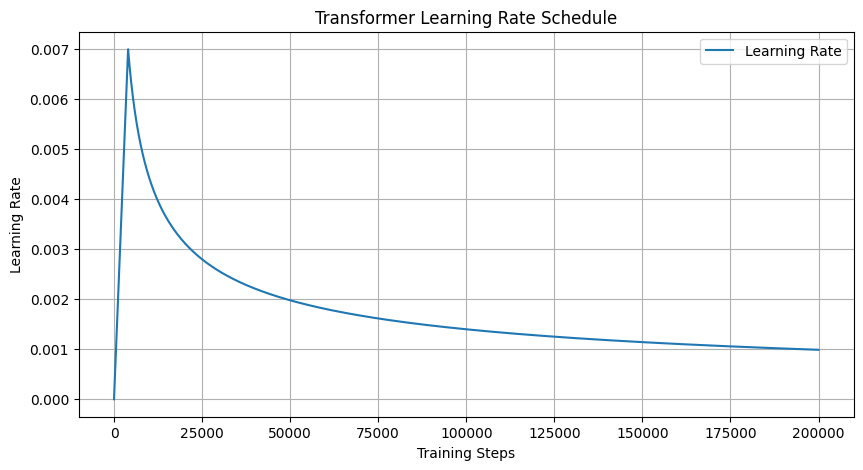

In [27]:
# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9) # 논문과 동일한 Adam

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=2000))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

print(device)

cuda


In [30]:
'''
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

'''
def train_step(model, batch, optimizer, loss_function, device, pad_id):
    model.train()

    # (input_ids, target_ids)로 받음
    input_ids, target_ids = [x.to(device) for x in batch]

    optimizer.zero_grad(set_to_none=True)

    # 포워드: 디코더 전용 LM은 입력 하나 / loss = loss_function(logits.permute(0, 2, 1) 안해도 무방
    logits = model(input_ids)  # [B, T, V]

    # CE는 [N,V] vs [N] 형태 기대
    loss = loss_function(
        logits.reshape(-1, logits.size(-1)),
        target_ids.reshape(-1)
    )

    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target_ids, pad_id=pad_id)




In [31]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            # train_step 호출만 수정
            loss, acc = train_step(
                model, batch, optimizer, loss_function, device, pad_id=sp.pad_id()
            )
            total_loss += loss
            total_acc += acc

            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")


In [ ]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=38,  # 원하는 에폭 수
    device=device
)

'''
오버피팅이 나는 것 같습니다.
epoch를 60으로 했을때 수렴하는 38로 조정
'''

[Epoch 1, Step 0] Loss: 283.8943, Acc: 0.0008
[Epoch 1, Step 100] Loss: 235.7289, Acc: 0.0000
Epoch 1 Completed - Avg Loss: 228.2419, Avg Acc: 0.0006
[Epoch 2, Step 0] Loss: 122.8313, Acc: 0.0000
[Epoch 2, Step 100] Loss: 55.0532, Acc: 0.0439
Epoch 2 Completed - Avg Loss: 63.9011, Avg Acc: 0.0386
[Epoch 3, Step 0] Loss: 36.9635, Acc: 0.0924
[Epoch 3, Step 100] Loss: 30.0541, Acc: 0.1600
Epoch 3 Completed - Avg Loss: 31.1663, Avg Acc: 0.1541
[Epoch 4, Step 0] Loss: 27.2034, Acc: 0.2423
[Epoch 4, Step 100] Loss: 24.5576, Acc: 0.3021
Epoch 4 Completed - Avg Loss: 24.2719, Avg Acc: 0.2947
[Epoch 5, Step 0] Loss: 22.6323, Acc: 0.3455
[Epoch 5, Step 100] Loss: 20.4176, Acc: 0.3968
Epoch 5 Completed - Avg Loss: 21.1499, Avg Acc: 0.3907
[Epoch 6, Step 0] Loss: 18.9590, Acc: 0.4278
[Epoch 6, Step 100] Loss: 19.0542, Acc: 0.4336
Epoch 6 Completed - Avg Loss: 19.6883, Avg Acc: 0.4358
[Epoch 7, Step 0] Loss: 18.3687, Acc: 0.4480
[Epoch 7, Step 100] Loss: 19.2180, Acc: 0.4345
Epoch 7 Completed - Av

'\n오버피팅이 나는 것 같습니다.\n\n'

In [39]:
def decoder_inference(model, sentence, tokenizer, device='cuda'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN   = tokenizer.eos_id()
    MAX_LENGTH  = 64

    sentence = preprocess_sentence(sentence)
    prefix_text = f"<user> {sentence} $ <assistant>"
    prefix_ids  = tokenizer.encode(prefix_text)

    # 초기 입력: [BOS] + prefix
    input_ids = torch.tensor([[START_TOKEN] + prefix_ids], dtype=torch.long, device=device)

    # 금지 토큰: 생성 단계에서 막을 목록
    forbid_pieces = ["<user>", "<assistant>", "<label_0>", "<label_1>", "<label_2>", "$"]
    forbid_ids = [tokenizer.piece_to_id(p) for p in forbid_pieces if tokenizer.piece_to_id(p) >= 0]
    # EOS는 허용해야 종료 가능. BOS는 어차피 안 나옴.

    model.eval()
    with torch.no_grad():
        for _ in range(MAX_LENGTH):
            logits = model(input_ids)                  # [B, T, V]
            step_logits = logits[:, -1, :].clone()     # [B, V]

            # 금지 토큰 마스킹
            if forbid_ids:
                step_logits[:, forbid_ids] = -1e9

            next_id = torch.argmax(step_logits, dim=-1)  # 그리디

            if next_id.item() == END_TOKEN:
                break

            input_ids = torch.cat([input_ids, next_id.unsqueeze(1)], dim=1)

    # 프롬프트 뒤의 생성 구간만 반환
    prefix_len = 1 + len(prefix_ids)  # [BOS] + prefix
    generated = input_ids[:, prefix_len:]
    return generated.squeeze(0).tolist()
'''
훈련 할 적에 특수 토큰을 넣었더니 출력도 토큰이 같이나오는 현상 때문에
금지토큰을 마스킹.
'''

'\n훈련 할 적에 특수 토큰을 넣었더니 출력도 토큰이 같이나오는 현상 때문에\n금지토큰을 마스킹.\n'

In [40]:
def sentence_generation(model, sentence, tokenizer, device='cuda'):
    gen_ids = decoder_inference(model, sentence, tokenizer, device=device)

    # 생성 구간만 디코딩. 특수토큰 제거(혹시 섞였을 대비).
    forbids_ids = {
        tokenizer.bos_id(), tokenizer.eos_id(), tokenizer.pad_id(),
        tokenizer.piece_to_id("<user>"), tokenizer.piece_to_id("<assistant>"),
        tokenizer.piece_to_id("<label_0>"), tokenizer.piece_to_id("<label_1>"),
        tokenizer.piece_to_id("<label_2>"), tokenizer.piece_to_id("$")
    }
    clean_ids = [t for t in gen_ids if t not in forbids_ids and t < tokenizer.GetPieceSize()]

    predicted_sentence = tokenizer.decode(clean_ids)

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence


In [41]:
def query_to_llm(num, path, model, sp, device="cuda"):
    """
    num: 생성할 문장 개수
    path: ChatbotData.csv 경로
    model: 학습된 Transformer 모델
    sp: SentencePiece tokenizer
    """
    path = "ChatbotData.csv"
    df = pd.read_csv(path)
    sentences = []

    # Q 컬럼에서 랜덤으로 num개 추출
    sample_qs = random.sample(df["Q"].tolist(), num)

    for sentence in sample_qs:
        sentence = str(sentence).strip()
        sentence_generation(model, sentence, sp, device)


In [ ]:
'''
데이터에서 랜덤 추출
감정 토큰을 프리픽스 시켜서 추론하는 것이 맞는것인지?
'''

real = [
"오늘은 왜 이렇게 피곤하지?",
"내일 뭐 입을까?",
"밥은 먹었어?",
"요즘 너무 바빠서 힘들어.",
"주말에 뭐 할까 고민돼."
"날씨가 진짜 덥다.",
"커피를 너무 많이 마신 것 같아.",
"요즘 잠이 잘 안 와.",
"그냥 아무 생각 없이 쉬고 싶다.",
"오늘 하루는 평범했어.",
"이제 정말 끝인 것 같아.",
"연락이 점점 줄어들고 있어.",
"나만 힘든 걸까?",
"그 사람 생각이 자꾸 나.",
"미련이 남아서 괴롭다.",
"혼자 있는 게 익숙해지는 게 슬퍼.",
"마음이 식은 게 느껴져.",
"내가 뭘 잘못한 걸까.",
"아직도 그때 일이 떠올라.",
"사랑이 이렇게 아픈 줄 몰랐어.",
"오늘 그 사람 웃는 게 너무 예뻤어.",
"같이 있을 때 제일 행복해.",
"괜히 생각만 해도 기분이 좋아.",
"그 사람이랑 통화하면 하루가 즐거워져.",
"눈만 봐도 마음이 편해.",
"요즘 매일 설레.",
"사랑받는다는 느낌이 이런 걸까.",
"선물 고르면서 괜히 웃음 나왔어.",
"만나면 시간이 너무 빨리 가.",
"그냥 그 사람이 좋다.",
]

In [ ]:
'''
위 함수에서는 데이터에서 추출하였지만 real은 gpt를 통해 데이터에 존재하지않는
문장으로 추론.
'''

def depends_on_real():
    for i in real:
        sentence_generation(model, i, sp, device)

In [ ]:
depends_on_real()

입력 : 오늘은 왜 이렇게 피곤하지?
출력 : 좋은 사람 사람 .
입력 : 내일 뭐 입을까?
출력 : 좋은 사람 사람 .
입력 : 밥은 먹었어?
출력 : 좋은 사람 사람 .
입력 : 요즘 너무 바빠서 힘들어.
출력 : 좋은 사람 사람 .
입력 : 주말에 뭐 할까 고민돼.날씨가 진짜 덥다.
출력 : 더 많이 많이 많이 많이 많이 많이 많이 많이 많이 .
입력 : 커피를 너무 많이 마신 것 같아.
출력 : 더 많이 많이 많이 많이 많이 많이 많이 많이 많이 많이 많이 .
입력 : 요즘 잠이 잘 안 와.
출력 : 더 좋은 사람 .
입력 : 그냥 아무 생각 없이 쉬고 싶다.
출력 : 좋은 사람 사람 .
입력 : 오늘 하루는 평범했어.
출력 : 좋은 사람 사람 .
입력 : 이제 정말 끝인 것 같아.
출력 : 더 좋은 사람 .
입력 : 연락이 점점 줄어들고 있어.
출력 : 더 좋은 사람 .
입력 : 나만 힘든 걸까?
출력 : 좋은 사람 .
입력 : 그 사람 생각이 자꾸 나.
출력 : 좋은 사람 사람 .
입력 : 미련이 남아서 괴롭다.
출력 : 더 좋은 사람 .
입력 : 혼자 있는 게 익숙해지는 게 슬퍼.
출력 : 더 좋은 사람 .
입력 : 마음이 식은 게 느껴져.
출력 : 더 좋은 사람 .
입력 : 내가 뭘 잘못한 걸까.
출력 : 더 좋은 사람 .
입력 : 아직도 그때 일이 떠올라.
출력 : 더 좋은 사람 .
입력 : 사랑이 이렇게 아픈 줄 몰랐어.
출력 : 더 좋은 사람 .
입력 : 오늘 그 사람 웃는 게 너무 예뻤어.
출력 : 더 더 더 더 좋은 사람 .
입력 : 같이 있을 때 제일 행복해.
출력 : 좋은 사람 .
입력 : 괜히 생각만 해도 기분이 좋아.
출력 : 좋은 사람 사람 .
입력 : 그 사람이랑 통화하면 하루가 즐거워져.
출력 : 좋은 사람 사람 .
입력 : 눈만 봐도 마음이 편해.
출력 : 더 많이 많이 많이 많이 많이 많이 .
입력 : 요즘 매일 설레.
출력 : 좋은 사람 .
입력 : 사랑받는다는 느낌이 이런 걸까.
출력 : 좋은 사람 사람 .
입력 : 